In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [4]:
weather_raw = pd.read_csv("C:/Users/carro/OneDrive/Escritorio/CUNEF/Visualización/Datasets/datos-metereologicos-2021.csv")

weather = (
    weather_raw
    .assign(
        fecha=lambda df: pd.to_datetime(df["fecha"]),
        provincia=lambda df: df["provincia"].str.upper()
    )
    .assign(
        tmed=lambda df: df["tmed"].str.replace(",", ".", regex=False).astype(float),
        tmin=lambda df: df["tmin"].str.replace(",", ".", regex=False).astype(float),
        tmax=lambda df: df["tmax"].str.replace(",", ".", regex=False).astype(float),
        prec=lambda df: pd.to_numeric(
            df["prec"].astype(str).str.replace(",", ".", regex=False),
            errors="coerce"
        ).fillna(0.0)
    )
)

weather.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2021-01-01,4358X,DON BENITO,BADAJOZ,273,6.7,0.0,2.7,23:59,10.7,15:40,30.0,"2,5","7,8",15:40,"7,1","983,4",10,"980,5",05
1,2021-01-01,4220X,PUEBLA DE DON RODRIGO,CIUDAD REAL,486,4.8,0.0,-0.1,23:59,9.8,14:20,25.0,"1,4","7,2",02:50,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,C447A,TENERIFE NORTE AEROPUERTO,STA. CRUZ DE TENERIFE,632,12.8,0.7,10.1,02:22,15.5,12:38,33.0,"1,7","8,3",00:30,"0,0","952,1",Varias,"949,3",18
3,2021-01-01,6106X,ANTEQUERA,MALAGA,408,6.1,2.4,3.5,23:59,8.7,14:20,34.0,"2,5","8,9",20:40,NaN,"966,8",11,"963,9",06
4,2021-01-01,9698U,TALARN,LLEIDA,807,3.2,0.0,-1.6,23:00,7.9,13:40,25.0,"2,2","7,5",15:20,"4,6","912,9",00,"910,0",13


In [6]:
shp_path = 'C:/Users/carro/OneDrive/Escritorio/CUNEF/Visualización/Datasets/georef-spain-municipio/georef-spain-municipio-millesime.shp'
muni = (
    gpd.read_file(shp_path)
    .assign(prov_name_upper=lambda df: df['prov_name'].str.upper())
        )
muni.head()

,year,acom_code,acom_name,prov_code,prov_name,mun_code,mun_name,mun_area_co,mun_type,mun_name_lo,geometry,prov_name_upper
0,2022,09,Cataluña,08,Barcelona,08150,Orís,ESP,municipality,None,"POLYGON ((2.18054 42.04195, 2.18422 42.04286, ...",BARCELONA
1,2022,09,Cataluña,08,Barcelona,08183,Roda de Ter,ESP,municipality,None,"POLYGON ((2.29932 41.97058, 2.29912 41.97057, ...",BARCELONA
2,2022,09,Cataluña,08,Barcelona,08224,Sant Martí de Centelles,ESP,municipality,None,"POLYGON ((2.18623 41.78207, 2.19111 41.7816, 2...",BARCELONA
3,2022,09,Cataluña,08,Barcelona,08303,Vilanova de Sau,ESP,municipality,None,"POLYGON ((2.36592 41.97308, 2.3658 41.97354, 2...",BARCELONA
4,2022,07,Castilla y León,09,Burgos,09009,Albillos,ESP,municipality,None,"POLYGON ((-3.81281 42.29297, -3.80933 42.29609...",BURGOS


#### ¿En qué provincias de España se registraron más días de lluvia intensa (precipitación diaria ≥ 10 mm) durante el año 2021?

In [10]:
weather_lluvia = (
    weather
    .assign(lluvia_intensa=lambda df: (df["prec"] >= 10).astype(int))
)

lluvia_por_prov = (
    weather_lluvia
    .groupby("provincia", as_index=False)
    .agg(dias_lluvia_intensa=("lluvia_intensa", "sum"))
)

lluvia_por_prov.head()

,provincia,dias_lluvia_intensa
0,A CORUÑA,313
1,ALBACETE,47
2,ALICANTE,49
3,ALMERIA,25
4,ARABA/ALAVA,51


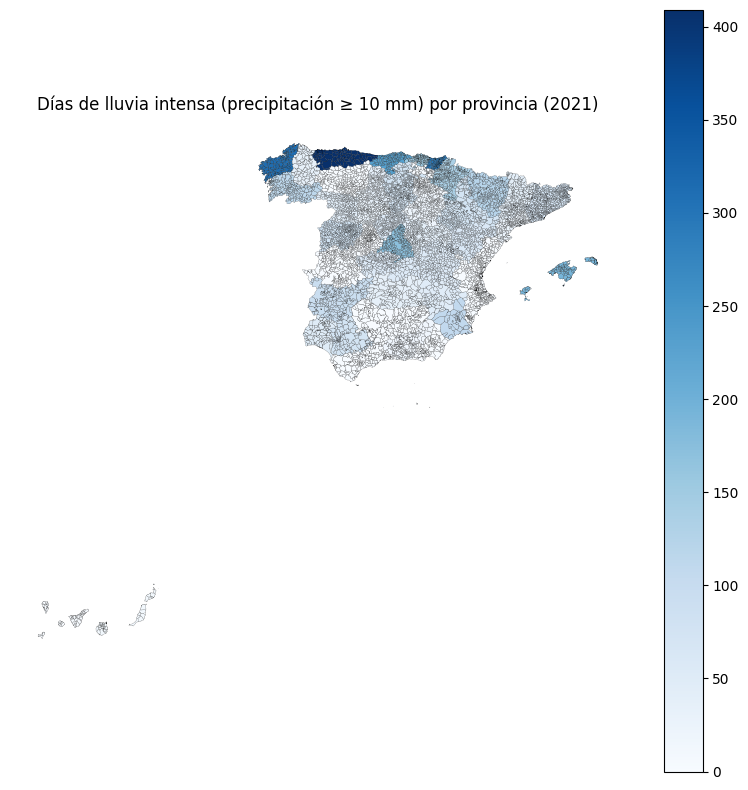

In [11]:
muni_lluvia = muni.merge(
    lluvia_por_prov,
    left_on="prov_name_upper",
    right_on="provincia",
    how="left"
)

muni_lluvia["dias_lluvia_intensa"] = muni_lluvia["dias_lluvia_intensa"].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

muni_lluvia.plot(
    column="dias_lluvia_intensa",
    ax=ax,
    legend=True,
    cmap="Blues",
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Días de lluvia intensa (precipitación ≥ 10 mm) por provincia (2021)")
ax.axis("off")

plt.tight_layout()
plt.show()

#### ¿En qué provincias de España fue mayor la amplitud térmica media diaria (tmax − tmin) durante el año 2021?

In [12]:
weather_amp = (
    weather
    .assign(amplitud_termica=lambda df: df["tmax"] - df["tmin"])
)

amp_por_prov = (
    weather_amp
    .groupby("provincia", as_index=False)
    .agg(amplitud_termica_media=("amplitud_termica", "mean"))
)

amp_por_prov.head()

,provincia,amplitud_termica_media
0,A CORUÑA,7.306807
1,ALBACETE,11.839231
2,ALICANTE,10.704083
3,ALMERIA,9.416903
4,ARABA/ALAVA,11.486986


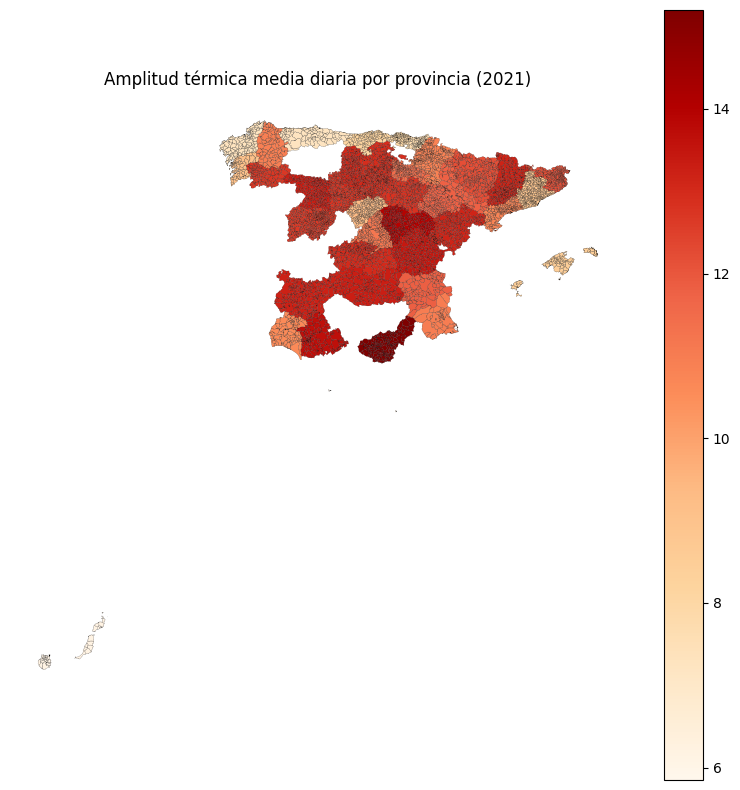

In [13]:
muni_amp = muni.merge(
    amp_por_prov,
    left_on="prov_name_upper",
    right_on="provincia",
    how="left"
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

muni_amp.plot(
    column="amplitud_termica_media",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Amplitud térmica media diaria por provincia (2021)")
ax.axis("off")

plt.tight_layout()
plt.show()